Analyses properties of decorrelation and whitening methods for decorrelated networks

In [12]:
import numpy as np
import torch
import torch.nn as nn
from decorrelation.decorrelation import Decorrelation, DecorLinear, DecorConv2d
import matplotlib.pyplot as plt
import matplotlib
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
from decorrelation.utils import train
import argparse
from decorrelation.plotting import *

# automatic reloading of modules when they change
%load_ext autoreload
%autoreload 2

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Grayscale(1),
        transforms.Normalize((0.5), (0.5)),
        # torch.flatten # not necessary but useful for debugging
        ])

train_data = MNIST(root='~/Data', train=True, download=True, transform=transform)
train_data = Subset(train_data, np.random.permutation(len(train_data.data))[:1000])
train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=0, drop_last=True)

In [3]:
args = argparse.Namespace(lr=0.0, kappa=1e-2, decor_lr=1e-1, bias_lr=0.0, epochs=20)

model = Decorrelation(784, decor_lr=args.decor_lr, bias_lr=args.bias_lr, kappa=args.kappa).to(device)

lossfun = lambda x, y: nn.Parameter(torch.zeros(1, device=device, dtype=float), requires_grad=True)

res = train(args, model, lossfun, train_loader, device)

epoch 0  	time:0.000 s	bp loss: 0.000000	decorrelation loss: 2.578500
epoch 1  	time:0.341 s	bp loss: 0.000000	decorrelation loss: 1.094406
epoch 2  	time:0.515 s	bp loss: 0.000000	decorrelation loss: 1.094292
epoch 3  	time:0.284 s	bp loss: 0.000000	decorrelation loss: 1.091810
epoch 4  	time:0.286 s	bp loss: 0.000000	decorrelation loss: 1.094840
epoch 5  	time:0.324 s	bp loss: 0.000000	decorrelation loss: 1.098934
epoch 6  	time:0.377 s	bp loss: 0.000000	decorrelation loss: 1.093100
epoch 7  	time:0.462 s	bp loss: 0.000000	decorrelation loss: 1.089301
epoch 8  	time:0.283 s	bp loss: 0.000000	decorrelation loss: 1.087551
epoch 9  	time:0.282 s	bp loss: 0.000000	decorrelation loss: 1.088307
epoch 10 	time:0.287 s	bp loss: 0.000000	decorrelation loss: 1.091197
epoch 11 	time:0.459 s	bp loss: 0.000000	decorrelation loss: 1.096322
epoch 12 	time:0.473 s	bp loss: 0.000000	decorrelation loss: 1.091934
epoch 13 	time:0.308 s	bp loss: 0.000000	decorrelation loss: 1.089449
epoch 14 	time:0.247

layer 1:

mean covariance before decorrelation: 0.56
mean variance before decorrelation: 0.93

mean covariance after decorrelation: 0.22
mean variance after decorrelation: 0.55



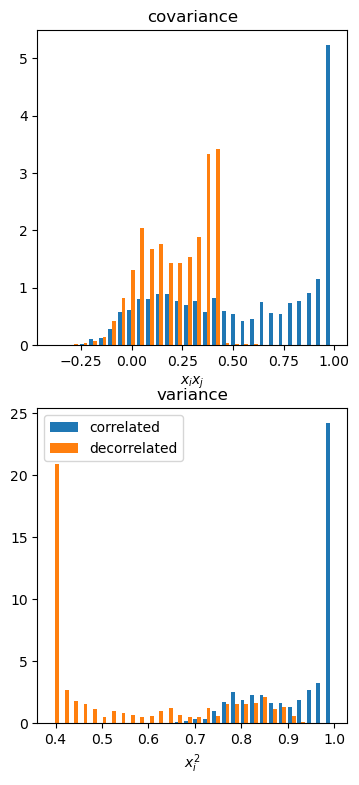

In [4]:
init_model = Decorrelation(784, decor_lr=args.decor_lr, bias_lr=args.bias_lr, kappa=args.kappa).to(device)
plot_correlations(init_model, model, train_loader, device)

In [5]:
args = argparse.Namespace(lr=1e-4, decor_lr=1e-1, bias_lr=0.0, kappa=1e-2, epochs=10)

class Model(nn.Sequential):
    def __init__(self, in_features, args):
        super().__init__(DecorLinear(in_features, 100, decor_lr=args.decor_lr, bias_lr=args.bias_lr, kappa=args.kappa))

    def forward(self, x):
        return super().forward(x.view(len(x), -1))
    
model = Model(784, args).to(device)

lossfun = torch.nn.CrossEntropyLoss().to(device)

res = train(args, model, lossfun, train_loader, device)

epoch 0  	time:0.000 s	bp loss: 4.987134	decorrelation loss: 2.582504
epoch 1  	time:0.319 s	bp loss: 4.503624	decorrelation loss: 1.090921
epoch 2  	time:0.262 s	bp loss: 3.627781	decorrelation loss: 1.094164
epoch 3  	time:0.266 s	bp loss: 2.994849	decorrelation loss: 1.095831
epoch 4  	time:0.250 s	bp loss: 2.593358	decorrelation loss: 1.095375
epoch 5  	time:0.255 s	bp loss: 2.332677	decorrelation loss: 1.092017
epoch 6  	time:0.290 s	bp loss: 2.157258	decorrelation loss: 1.091103
epoch 7  	time:0.287 s	bp loss: 2.012950	decorrelation loss: 1.093635
epoch 8  	time:0.273 s	bp loss: 1.894957	decorrelation loss: 1.091651
epoch 9  	time:0.251 s	bp loss: 1.799702	decorrelation loss: 1.094625
epoch 10 	time:0.247 s	bp loss: 1.708792	decorrelation loss: 1.091785


layer 1:

mean covariance before decorrelation: 0.56
mean variance before decorrelation: 0.93

mean covariance after decorrelation: 0.22
mean variance after decorrelation: 0.55



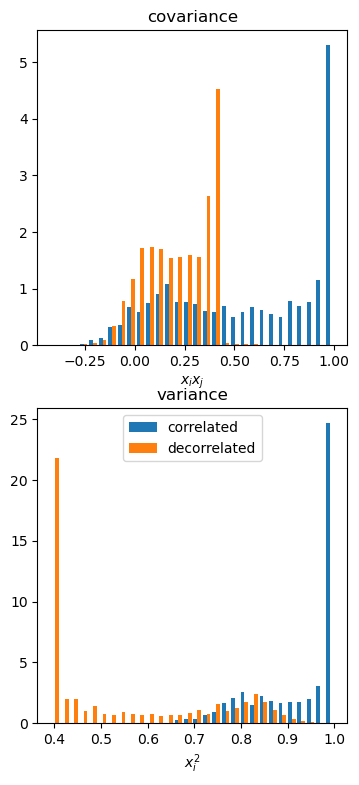

In [6]:
init_model = Model(784, args).to(device)
plot_correlations(init_model, model, train_loader, device)

In [14]:
args = argparse.Namespace(lr=1e-4, decor_lr=1e-1, bias_lr=0.0, kappa=1e-2, epochs=10)

class Model(nn.Sequential):
    def __init__(self, in_features, args):
        super().__init__(DecorLinear(in_features, 100, decor_lr=args.decor_lr, bias_lr=args.bias_lr, kappa=args.kappa),
                        nn.LeakyReLU(),
                        DecorLinear(100, 10, decor_lr=args.decor_lr, bias_lr=args.bias_lr, kappa=args.kappa)
                        )

    def forward(self, x):
        return super().forward(x.view(len(x), -1))

# class Model(nn.Sequential):
#     def __init__(self, in_features, eta, whiten):
#         super().__init__(Decorrelation(in_features, bias=False, eta=eta, whiten=whiten),
#                         nn.BatchNorm1d(in_features),
#                         nn.Linear(in_features, 100),
#                         nn.LeakyReLU(),
#                         Decorrelation(100, bias=False, eta=eta, whiten=whiten),
#                         nn.BatchNorm1d(100),
#                         nn.Linear(100, 10)
#                         )
    
model = Model(784, args).to(device)

lossfun = torch.nn.CrossEntropyLoss().to(device)

res = train(args, model, lossfun, train_loader, device)

epoch 0  	time:0.000 s	bp loss: 2.466652	decorrelation loss: 6.813346
epoch 1  	time:0.460 s	bp loss: 2.374684	decorrelation loss: 2.747993
epoch 2  	time:0.507 s	bp loss: 2.126681	decorrelation loss: 1.128617
epoch 3  	time:0.479 s	bp loss: 1.818317	decorrelation loss: 1.188578
epoch 4  	time:0.457 s	bp loss: 1.498712	decorrelation loss: 1.335160
epoch 5  	time:0.511 s	bp loss: 1.218091	decorrelation loss: 1.453138
epoch 6  	time:0.469 s	bp loss: 1.036211	decorrelation loss: 1.469717
epoch 7  	time:0.454 s	bp loss: 0.896981	decorrelation loss: 1.456682
epoch 8  	time:0.461 s	bp loss: 0.826158	decorrelation loss: 1.490682
epoch 9  	time:0.481 s	bp loss: 0.771891	decorrelation loss: 1.481043
epoch 10 	time:0.635 s	bp loss: 0.763322	decorrelation loss: 1.606067


layer 1:

mean covariance before decorrelation: 0.58
mean variance before decorrelation: 0.93

mean covariance after decorrelation: 0.00
mean variance after decorrelation: 0.75

layer 2:

mean covariance before decorrelation: 0.07
mean variance before decorrelation: 0.20

mean covariance after decorrelation: 0.05
mean variance after decorrelation: 1.00



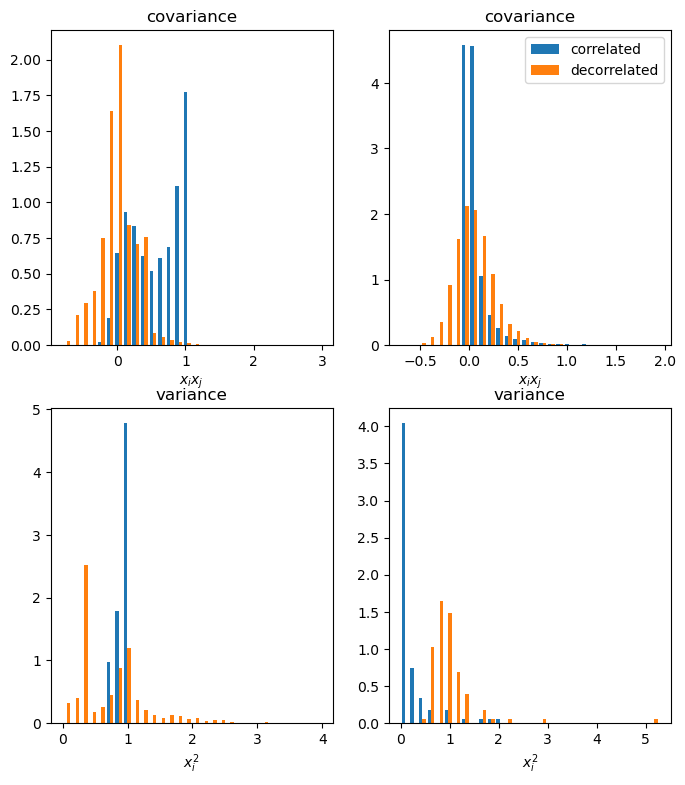

In [15]:
init_model = Model(784, args).to(device)
plot_correlations(init_model, model, train_loader, device)